In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
from keras.optimizers import Adam
# from sklearn.utils.class_weight import compute_class_weight
# from scikeras.wrappers import KerasClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from newsapi import NewsApiClient
import string
import spacy
from sklearn.utils import resample
import pickle

### Project
- Project group, Adam and Roger
- SIN wants a model that can be used to see if the title of an article can determine if it is fake information.
- Classify text, 1 = Fake 0 = Real

### Read csv files

In [2]:
data = pd.read_csv("../csv_file/big_data.csv") 
test_data = pd.read_csv("../csv_file/test_data.csv")

In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download spaCy model
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [5]:
# Extract texts and labels
texts = data["headlines"]
labels = data["outcome"]

In [6]:
labels

0        0
1        0
2        0
3        0
4        0
        ..
19568    1
19569    0
19570    0
19571    1
19572    1
Name: outcome, Length: 19573, dtype: int64

In [7]:
pretrained_word_vectors = "../pretrained_word_vectors/glove.6B.100d.txt"

In [43]:
def create_embedding_matrix(word_index, embedding_path):
    embedding_index = {}
    with open(embedding_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs

    embedding_dim = len(coefs)
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [20]:
def softmax(x, axis=None):
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / exp_x.sum(axis=axis, keepdims=True)

In [ ]:
embedding_matrix = create_embedding_matrix(word_index, pretrained_word_vectors)

In [7]:
# Preprocessing
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Tokenization using spaCy
    tokens = nlp(text)
    tokens = [token.text for token in tokens]
    
    # Punctuation Removal
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Stop Word Removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens


# Apply preprocessing to all texts

def preprocess_and_undersample(X, y):
    # Apply text preprocessing to your text data
    preprocessed_texts = [preprocess_text(text) for text in X]

    # Combine preprocessed text and labels for undersampling
    preprocessed_data = pd.DataFrame({'headlines': preprocessed_texts, 'outcome': y})

    # Separate majority and minority classes
    majority_class = preprocessed_data[preprocessed_data['outcome'] == 1]
    minority_class = preprocessed_data[preprocessed_data['outcome'] == 0]

    # Undersample the majority class
    majority_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)
    
    # Combine minority class and undersampled majority class
    undersampled_data = pd.concat([majority_undersampled, minority_class])
    
    # Separate features and labels after undersampling
    X_undersampled = undersampled_data['headlines']
    y_undersampled = undersampled_data['outcome']

    print(y_undersampled.value_counts())

    return X_undersampled, y_undersampled

# X_train_undersampled, y_train_undersampled = preprocess_and_undersample(texts, labels)
preprocessed_texts = [preprocess_text(text) for text in texts]



# Tokenization using Keras Tokenizer
# max_words = 27458
max_words = 15000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(preprocessed_texts)
sequences = tokenizer.texts_to_sequences(preprocessed_texts)

# Padding sequences
maxlen = 75
X = pad_sequences(sequences, maxlen=maxlen)

# Convert labels to numpy array
y = np.array(labels)

In [8]:
# Build the RNN model
embedding_dim = 50  # Dimensionality of the embedding space
hidden_units = 50  # Number of LSTM units

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Train the model
epochs = 5
batch_size = 64

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/5


196/196 [==============================] - 11s 43ms/step - loss: 0.3834 - accuracy: 0.8169 - val_loss: 0.2121 - val_accuracy: 0.9154
Epoch 2/5
196/196 [==============================] - 8s 42ms/step - loss: 0.1481 - accuracy: 0.9476 - val_loss: 0.2061 - val_accuracy: 0.9218
Epoch 3/5
196/196 [==============================] - 8s 42ms/step - loss: 0.0787 - accuracy: 0.9734 - val_loss: 0.2245 - val_accuracy: 0.9246
Epoch 4/5
196/196 [==============================] - 8s 40ms/step - loss: 0.0461 - accuracy: 0.9858 - val_loss: 0.2517 - val_accuracy: 0.9186
Epoch 5/5
123/123 [==============================] - 1s 10ms/step - loss: 0.2899 - accuracy: 0.9149
Test Accuracy: 91.49%


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 75, 50)            750000    
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 770251 (2.94 MB)
Trainable params: 770251 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

123/123 [==============================] - 1s 7ms/step


In [11]:
y_pred[]

array([[9.9950373e-01],
       [6.9526129e-04],
       [7.4187249e-01],
       ...,
       [9.9872231e-01],
       [9.9941117e-01],
       [9.9936455e-01]], dtype=float32)

In [14]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

X_padded = pad_sequences(sequences, maxlen=maxlen)

# Assuming loaded_keras_model is your loaded sequential model
probabilities = model.predict(X_padded)

# Assuming probabilities[:, 0] corresponds to the only class in your model
for i, probability in enumerate(probabilities[:, 0]):
    probability *= 100
    
    pred = y_pred_binary[i]
    if pred == 1:
        pred = "Fake"
    else:
        pred = "Real"
        probability = 100 - probability
        
    print(f"Row {i+1}: Prediction = {pred}, Probability = {probability:.2f}%")

612/612 [==============================] - 5s 9ms/step
Row 1: Prediction = Fake, Probability = 97.88%
Row 2: Prediction = Real, Probability = 99.98%
Row 3: Prediction = Real, Probability = 99.99%
Row 4: Prediction = Fake, Probability = 0.01%
Row 5: Prediction = Fake, Probability = 1.60%
Row 6: Prediction = Fake, Probability = 0.01%
Row 7: Prediction = Fake, Probability = 31.49%
Row 8: Prediction = Real, Probability = 99.78%
Row 9: Prediction = Fake, Probability = 0.01%
Row 10: Prediction = Real, Probability = 99.98%
Row 11: Prediction = Fake, Probability = 0.02%
Row 12: Prediction = Fake, Probability = 95.98%
Row 13: Prediction = Real, Probability = 99.81%
Row 14: Prediction = Fake, Probability = 4.17%
Row 15: Prediction = Fake, Probability = 2.33%
Row 16: Prediction = Fake, Probability = 0.00%
Row 17: Prediction = Real, Probability = 99.99%
Row 18: Prediction = Real, Probability = 89.58%
Row 19: Prediction = Fake, Probability = 0.01%
Row 20: Prediction = Fake, Probability = 6.23%
Row 

IndexError: index 3915 is out of bounds for axis 0 with size 3915

123/123 [==============================] - 4s 20ms/step


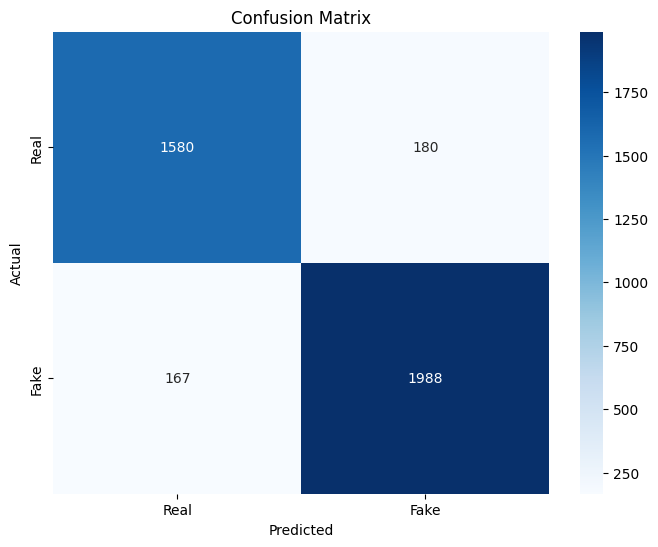

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      1760
           1       0.92      0.92      0.92      2155

    accuracy                           0.91      3915
   macro avg       0.91      0.91      0.91      3915
weighted avg       0.91      0.91      0.91      3915



In [45]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

In [46]:
probabilities = 1 / (1 + np.exp(-y_pred))

for i, probability in enumerate(probabilities):
    probability_value = float(probability[0]) * 100  # Extracting the first element
    print(f"Row {i+1}: Probability = {probability_value:.2f}%")

Row 1: Probability = 73.09%
Row 2: Probability = 50.00%
Row 3: Probability = 69.50%
Row 4: Probability = 73.10%
Row 5: Probability = 73.03%
Row 6: Probability = 73.10%
Row 7: Probability = 73.10%
Row 8: Probability = 50.00%
Row 9: Probability = 69.71%
Row 10: Probability = 50.00%
Row 11: Probability = 71.66%
Row 12: Probability = 72.73%
Row 13: Probability = 50.00%
Row 14: Probability = 72.75%
Row 15: Probability = 73.09%
Row 16: Probability = 72.11%
Row 17: Probability = 50.04%
Row 18: Probability = 50.00%
Row 19: Probability = 73.10%
Row 20: Probability = 73.10%
Row 21: Probability = 73.10%
Row 22: Probability = 73.10%
Row 23: Probability = 72.32%
Row 24: Probability = 50.01%
Row 25: Probability = 73.08%
Row 26: Probability = 50.23%
Row 27: Probability = 50.00%
Row 28: Probability = 73.10%
Row 29: Probability = 68.84%
Row 30: Probability = 73.08%
Row 31: Probability = 50.00%
Row 32: Probability = 50.01%
Row 33: Probability = 50.05%
Row 34: Probability = 72.78%
Row 35: Probability = 5

In [ ]:
# Save the tokenizer to a file

with open('tokenizer/tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [ ]:
# save the model

model.save("trained_models/keras_model.h5")

In [9]:
newsapi = NewsApiClient(api_key='2ec72918ca08491b885785649a92cfb7')
covid_articles = newsapi.get_everything(q='covid',
                                        language='en',
                                        sort_by='relevancy',
                                        page=1)

clean_title = []
for index, i in enumerate(covid_articles['articles']):
    row = i['title']
    row = row.split(" ")
    row = ' '.join(letter for letter in row if letter.isalnum() or letter == "COVID-19")
    if "COVID-19" in row:
        row = row.replace("COVID-19", "COVID19")
    row = row.lower()
    clean_title.append(row)

In [10]:
# if testing with newsapi
# X = clean_title
# obs! can not evaluate with y

In [47]:
X = test_data["headlines"]
y = test_data["outcome"]

In [10]:
test_data.head()

,headlines,outcome
0,CDC has given more than $200M to address #COVI...,0
1,#IndiaFightsCorona TEST TRACK TREAT- effective...,0
2,"Ireland's entire cabinet will ""restrict their ...",0
3,The Chairman of the Republican Party of Texas ...,1
4,Iranians have published a report saying that c...,1


In [49]:
preprocessed_title = [preprocess_text(text) for text in X]

In [50]:
new_sequences = tokenizer.texts_to_sequences(preprocessed_title)
new_padded_sequence = pad_sequences(new_sequences, maxlen=maxlen)

In [15]:
# load model
loaded_model = load_model("trained_models/keras_model.h5")

In [51]:
predictions = model.predict(new_padded_sequence)

7/7 [==============================] - 0s 19ms/step


In [55]:
threshold = 0.5

In [56]:
binary_predictions = (predictions >= threshold).astype(int)

In [19]:
for index, title in enumerate(X):
    prediction = binary_predictions[index]
    if prediction == 1:
        prediction = "Fake"
    else:
        prediction = "Real"
    print(f"Title: {title}")
    print(f"Prediction: {prediction}")
    print("=" * 50)

Title: CDC has given more than $200M to address #COVID19 health disparities among American Indian &amp; Alaska Native people who have suffered a disproportionate burden of illness. Funding will broaden access to COVID-19 resources across tribal communities. https://t.co/MG8e5TWigl https://t.co/KwoPLuxG4g
Prediction: Real
Title: #IndiaFightsCorona TEST TRACK TREAT- effective implementation by the Centre and States/UTs has ensured that India has one of lowest #COVID19 cases and deaths per million population compared to several other countries. https://t.co/Caqhv0M0rK
Prediction: Real
Title: Ireland's entire cabinet will "restrict their movements" after the health minister felt unwell and was tested for #coronavirus it has been reported https://t.co/i5zO9bFugY
Prediction: Fake
Title: The Chairman of the Republican Party of Texas said the recovery rate for COVID-19 is 99.9% in Texas. That’s False. @PolitiFactTexas https://t.co/GmUXoVT2Dh https://t.co/ltIHWPchJM
Prediction: Real
Title: Iran

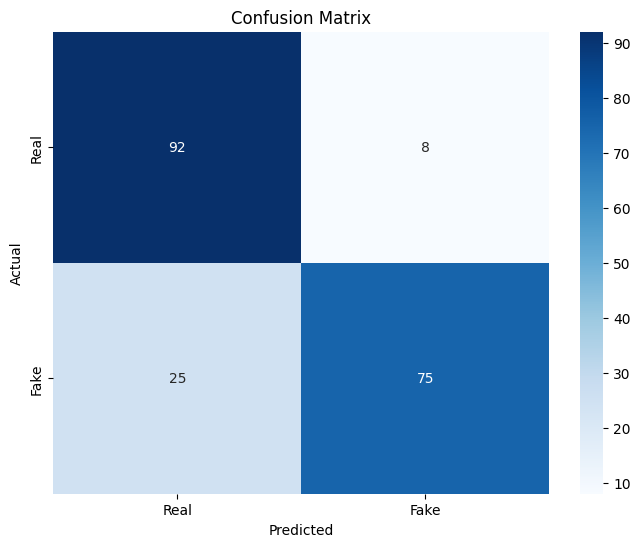

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       100
           1       0.90      0.75      0.82       100

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200



In [20]:
cm = confusion_matrix(y, binary_predictions)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(y, binary_predictions))